# Distributed Tensorflow: Fashion MNIST Dataset

Analytics zoo now features the ability to do distributed tensorflow using the Apache Spark framework on Analytics Zoo.  While the BigDL models are powerful in many ways, there is also an advantage to being able to use the better-known Tensorflow engine. 

Vanilla Tensorflow, however, has some major limitations out of the box.  Parallelization is challenging absent an additional framework that allows us to distribute our workload.  Apache Spark is the perfect such framework -- which is now very mature and able to easily handle heavy workloads on Big Data.

This dataset uses the higher-level Keras API to to run the fashion MNIST dataset.

The classic MNIST dataset is not a particularly challenging dataset, but its small images size of 28x28 makes it commonly used as a demonstration.  The Fashion MNIST uses the same image size, but instead substitutes items of fashion.  It is a significantly more challenging and interesting problem.

In [1]:
%matplotlib inline
from zoo import init_nncontext
sc = init_nncontext()  # create NNContext from Analytics Zoo


In [2]:

# Some variables we cn chanage.

max_epoch = 5 # How many epochs to run
data_num = 6000 # How much data to train on.
val_num = 600 # How much data to validate on.


### Load the Data

Here we are going to load the data, and convert to RDD

In [3]:
import tensorflow as tf

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Convert to RDD
x_train_rdd = sc.parallelize(x_train[:data_num])
y_train_rdd = sc.parallelize(y_train[:data_num])
x_test_rdd = sc.parallelize(x_test[:data_num])
y_test_rdd = sc.parallelize(y_test[:data_num])
training_rdd = x_train_rdd.zip(y_train_rdd)
testing_rdd = x_test_rdd.zip(y_test_rdd)



x_train shape: (60000, 28, 28) y_train shape: (60000,)


## Sample Images

Here are some sample images.

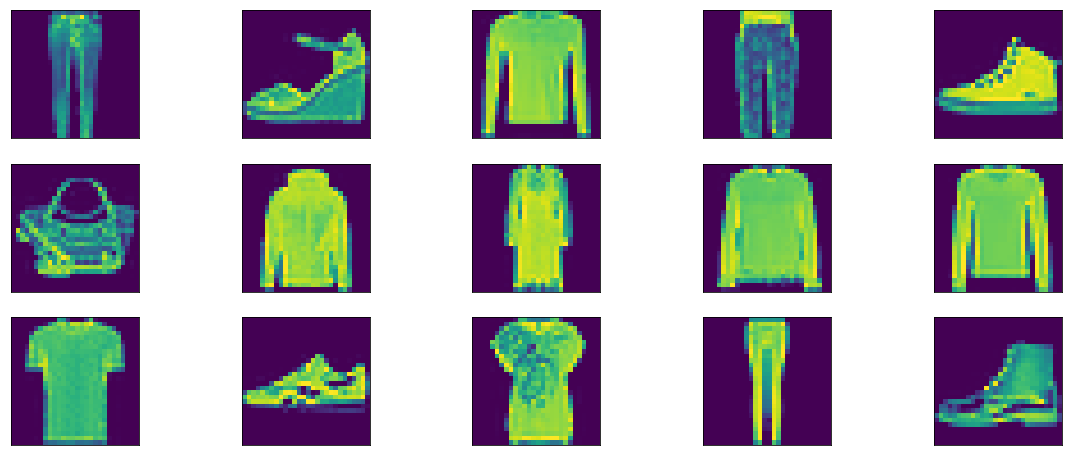

In [4]:
import numpy as np
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    

In [5]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


In [6]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[val_num:], x_train[:val_num] 
(y_train, y_valid) = y_train[val_num:], y_train[:val_num]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')


x_train shape: (59400, 28, 28, 1) y_train shape: (59400, 10)
59400 train set
600 validation set
10000 test set


## Tensorflow Dataset

We will now create a TFDataset, which is a tensorflow dataset, loaded into Apache Spark. This will allow us to use Tensorflow trainign and deployment in a distributed fashion.

In [7]:
from zoo.pipeline.api.net import TFDataset
dataset = TFDataset.from_rdd(training_rdd,  # Training data
                             names=["features", "labels"],  # names of keys: features and labels
                             shapes=[[28, 28, 1], []],  #Input Shape is image, ouput is a scalar (prediction)
                             types=[tf.float32, tf.int32],  #input are floats, output is an integer
                             batch_size=280, # Batch size to use in training
                             val_rdd=testing_rdd  # What to use as a validation RDD
                             )




### Building the Model

This model is a simple, feedforward Neural Network with two hidden layers.

We are using Keras API in Tensorflow, which is becoming the new high-level API standard in Tensorflow. This is *not* the Zoo Keras API -- this is the Tensorflow Keras API running on top of a Spark RDD running in BigDL.

This is exciting because it allows us to use Zoo's superior distribution capabilities on Spark to perform distributed Tensorflow

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

data = Input(shape=[28, 28, 1])

x = Flatten()(data)
x = Dense(64, activation='relu')(x)     # Hidden Layer: 64 Neurons
x = Dense(64, activation='relu')(x)     # Hidden Layer: 64 Neurons
predictions = Dense(10, activation='softmax')(x)  # Output is label 0-9

model = Model(inputs=data, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


### Training

We are going to train using Zoo's TFOptimizer.  This will take the data and train.  We are going to be using RMSProp as our optimizer, with accuracy as our validation metci



In [9]:
from zoo.pipeline.api.net import TFOptimizer
from bigdl.optim.optimizer import TrainSummary, ValidationSummary, MaxEpoch


optimizer = TFOptimizer.from_keras(model, dataset)

optimizer.set_train_summary(TrainSummary("/tmp/fashion-mnist_log", "mnist"))
optimizer.set_val_summary(ValidationSummary("/tmp/fashion-mnist_log", "mnist"))
# kick off training
optimizer.optimize(end_trigger=MaxEpoch(max_epoch))

model.save_weights("/tmp/fashion-mnist_keras.h5")




creating: createRMSprop
creating: createClassNLLCriterion
creating: createLoss
creating: createZooKerasSparseCategoricalAccuracy
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.
creating: createTFTrainingHelper
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createIdentityCriterion
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createValidationSummary
creating: createMaxEpoch


### Results

We are going to examine some of the results.  Here we show some sample images and their values.  Red values indicate a misprediction, with the correct index printed afterward, while green values indicate a correct prediction.

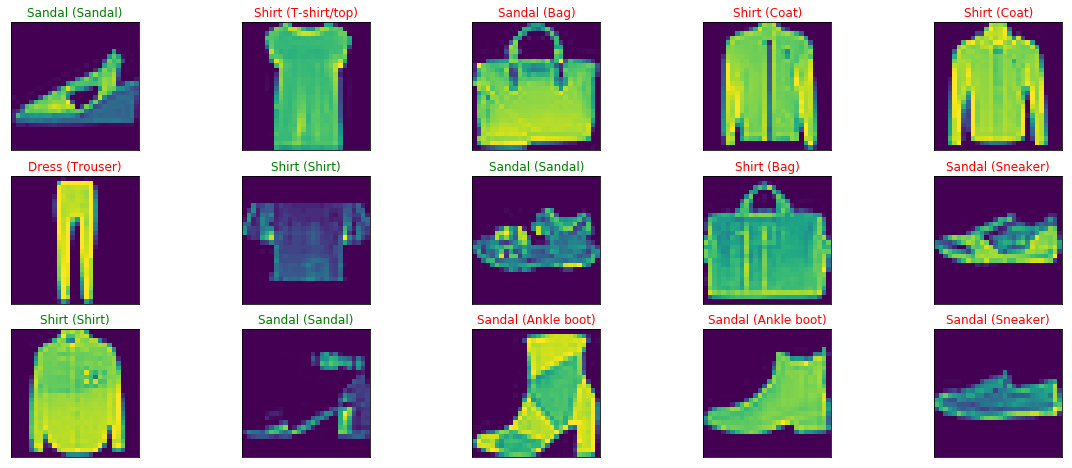

In [10]:
import matplotlib.pyplot as plt

y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

### Improving the Results

We only trained with a samll subset of the data to keep the notebook small and lightweight. However, we could and should train with more data.  We can also certainly train for more epochs!

Also, we should get and use a Convolutional Neural Network architecture similar to LeNet, rather than the current Dense Layers in a Multilayer Perceptron (MLP).